# Parte 2 - Modelos de Previsão

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA

## Importando os datasets da Parte 1

In [149]:

daily_m = pd.read_csv('../../data/Marcos/daily_m.csv')
hourly_m = pd.read_csv('../../data/Marcos/hourly_m.csv')
weekly_m.drop(['ano','mes','hora','min'], axis = 1, inplace=True)
log_data = pd.read_csv('../../data/Marcos/log_data.csv')
weekly_m_log = pd.read_csv('../../data/Marcos/weekly_m_return_log.csv')
data_test = pd.read_csv('../../data/ElectricDemandForecasting-DL-master_data_hourly_20140102_20191101_test.csv')

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(20,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
weekly_m.head()


KeyError: "['ano' 'mes' 'hora' 'min'] not found in axis"

## Tratando o dataset de teste

In [ ]:
data_test['datetime']=pd.to_datetime(data_test['datetime'], utc=True)
test_weekly = data_test.set_index('datetime').resample('W').mean()
test_weekly.head()
test_weekly.info()

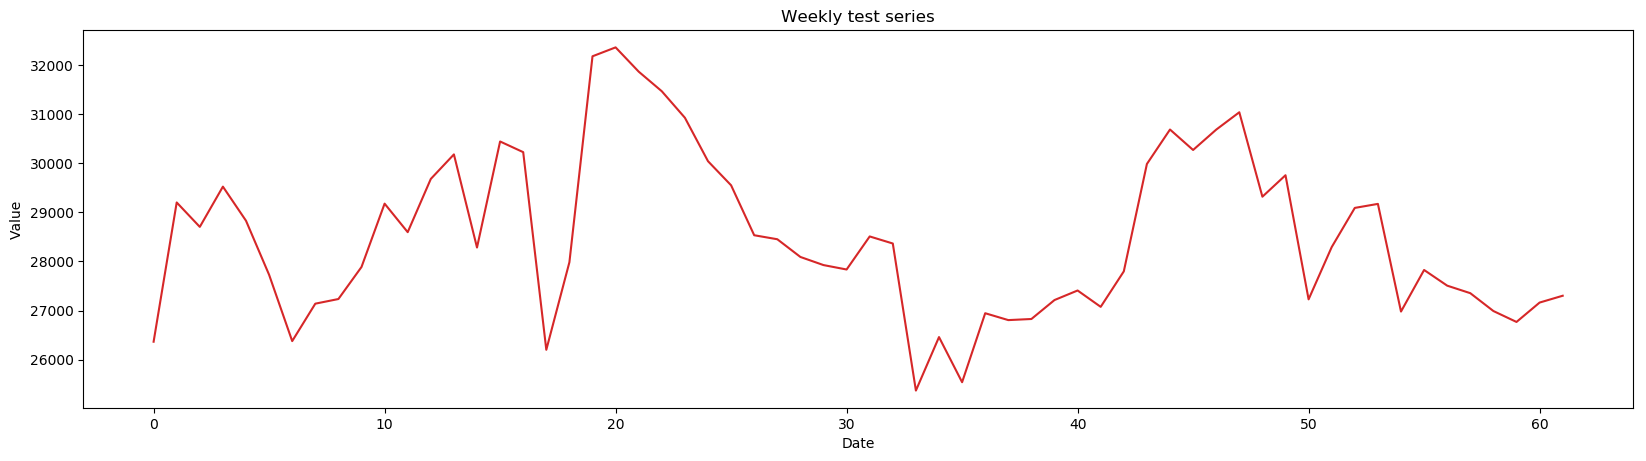

In [137]:
plot_df(test_weekly, x=test_weekly.index, y=test_weekly.value, title="Weekly test series")

### Aplicando a transformação logarítmica e retorno-logarítmico aos dados de teste

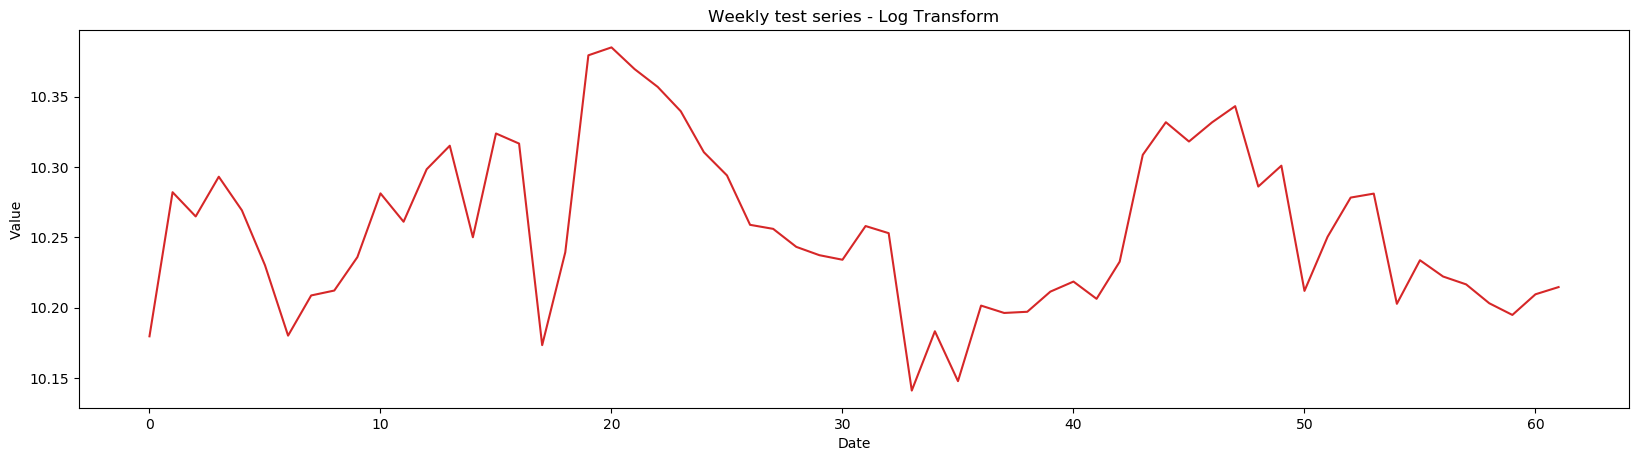

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 1 columns):
value    62 non-null float64
dtypes: float64(1)
memory usage: 568.0 bytes


,value
0,10.179745
1,10.282070
2,10.264862
3,10.293061
4,10.269212


In [138]:
log_data_test_w = np.log(test_weekly['value']).to_frame()
plot_df(log_data_test_w, x=log_data_test_w.index, y=log_data_test_w.value, title="Weekly test series - Log Transform")
log_data_test_w.info()
log_data_test_w.head()

In [139]:
weekly_m = weekly_m.set_index('datetime')
weekly_m.reset_index(inplace=True)
weekly_m.head()

,datetime,value,percentage
0,2014-01-05 00:00:00+00:00,27193.678694,0.334442
1,2014-01-12 00:00:00+00:00,28558.553571,0.333475
2,2014-01-19 00:00:00+00:00,30339.781746,0.333217
3,2014-01-26 00:00:00+00:00,30582.158730,0.333047
4,2014-02-02 00:00:00+00:00,30525.325397,0.333133


In [140]:
test_weekly.reset_index(inplace=True)
test_weekly.head()

,index,datetime,value,percentage
0,0,2018-09-02 00:00:00+00:00,26363.753333,0.333457
1,1,2018-09-09 00:00:00+00:00,29204.251984,0.333217
2,2,2018-09-16 00:00:00+00:00,28706.025794,0.333331
3,3,2018-09-23 00:00:00+00:00,29527.029762,0.333300
4,4,2018-09-30 00:00:00+00:00,28831.158730,0.333453


# Modelos de Previsão

## Modelo Trivial - Naive approach

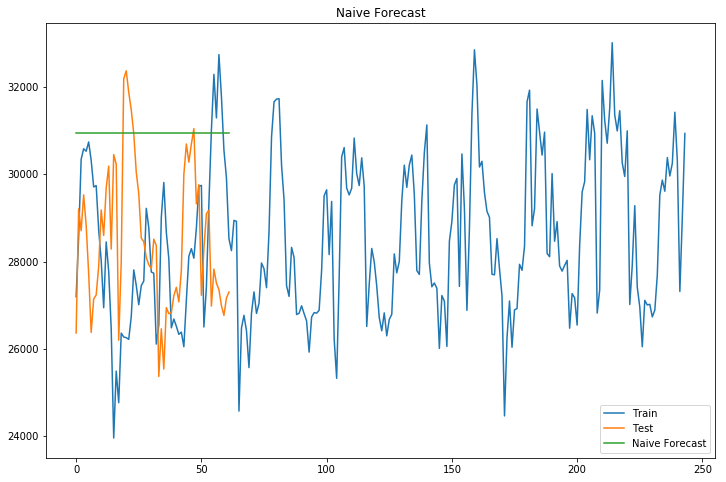

In [141]:

dd = np.asarray(weekly_m['value'])
y_hat = test_weekly.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(weekly_m.index, weekly_m['value'], label='Train')
plt.plot(test_weekly.index,test_weekly['value'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

## Modelo de Alisamento Exponencial 

In [143]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

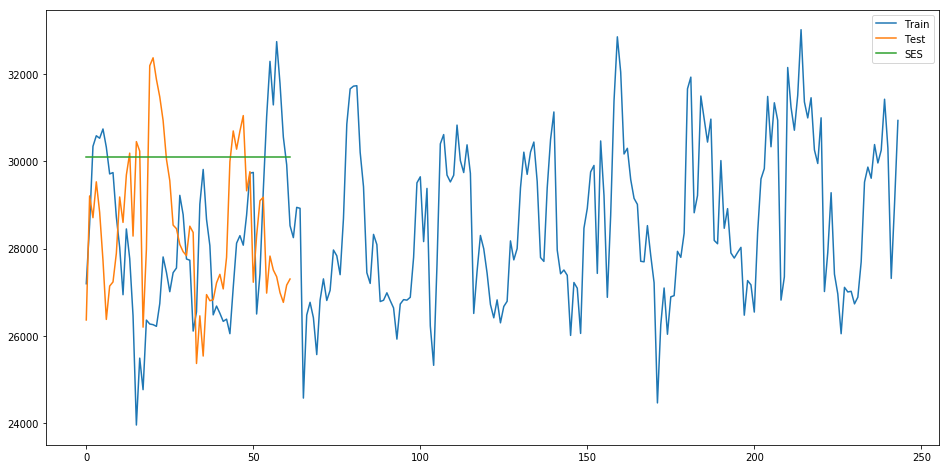

In [145]:
y_hat_avg = test_weekly.copy()
fit = SimpleExpSmoothing(np.asarray(weekly_m['value'])).fit(smoothing_level=0.6, optimized=False)
y_hat_avg['SES'] = fit.forecast(len(test_weekly))
plt.figure(figsize=(16,8))
plt.plot(weekly_m['value'], label='Train')
plt.plot(test_weekly['value'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

## Modelo de Holts-Winter

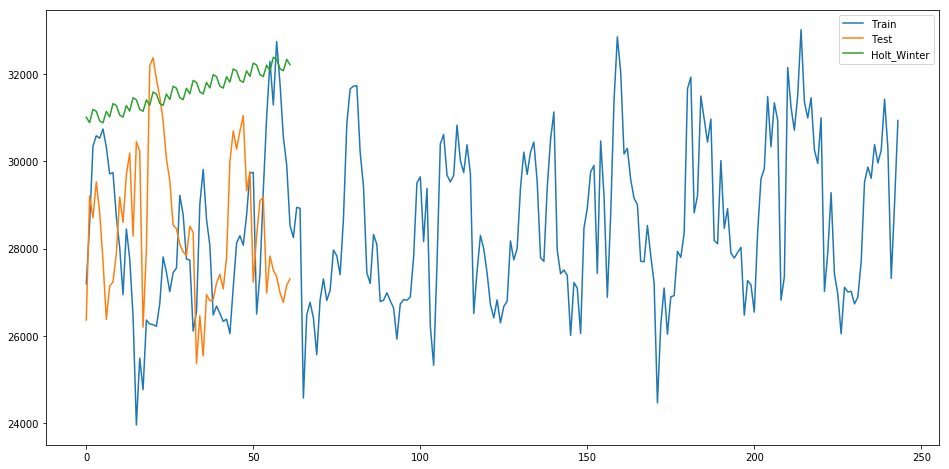

In [147]:
y_hat_avg = test_weekly.copy()
fit_hw = ExponentialSmoothing(np.asarray(weekly_m['value']),seasonal_periods=6,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_hw.forecast(len(test_weekly))
plt.figure(figsize=(16,8))
plt.plot(weekly_m['value'], label='Train')
plt.plot(test_weekly['value'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

## Modelo ARIMA

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  243
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2076.319
Method:                       css-mle   S.D. of innovations           1242.830
Date:                Tue, 13 Oct 2020   AIC                           4162.637
Time:                        21:16:56   BIC                           4180.102
Sample:                             1   HQIC                          4169.672
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.6698     51.383      0.149      0.881     -93.038     108.378
ar.L1.D.value    -0.0325      0.206     -0.158      0.875      -0.437       0.372
ma.L1.D.value    -0.0228      0.196     

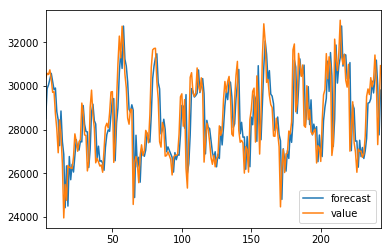

<Figure size 2160x720 with 0 Axes>

In [163]:
model = ARIMA(weekly_m.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
model_fit.plot_predict(dynamic=False)
plt.figure(figsize=(30,10))
plt.show()